In [1]:
"""
Anchor Box（アンカーボックス）の理解を深めるための最小コード

このスクリプトで体験できること
1) 画像サイズと特徴マップサイズから「アンカー（事前定義の箱）」を格子状に生成
2) GT（正解BBox）との IoU を計算
3) IoUに基づいて「正例/負例/無視」を割り当て（matching）
4) 正例アンカーに対して回帰ターゲット（t_x,t_y,t_w,t_h）を作る（encode）
5) 回帰ターゲットから予測BBoxを復元（decode）
"""

import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
import math
import numpy as np


# --------------------------
# 0) 基本：BBox表現
# --------------------------
# ここでは xyxy 形式（x1,y1,x2,y2）で統一します（画像座標）
# x1 < x2, y1 < y2 を想定


def xyxy_to_cxcywh(boxes: np.ndarray) -> np.ndarray:
    """(N,4) xyxy -> (N,4) cx,cy,w,h"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) * 0.5
    cy = (y1 + y2) * 0.5
    w = (x2 - x1)
    h = (y2 - y1)
    return np.stack([cx, cy, w, h], axis=1)


def cxcywh_to_xyxy(boxes: np.ndarray) -> np.ndarray:
    """(N,4) cx,cy,w,h -> (N,4) xyxy"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - w * 0.5
    y1 = cy - h * 0.5
    x2 = cx + w * 0.5
    y2 = cy + h * 0.5
    return np.stack([x1, y1, x2, y2], axis=1)


def clip_xyxy(boxes: np.ndarray, W: int, H: int) -> np.ndarray:
    """画像範囲にクリップ（境界外に出たアンカー/予測を収める）"""
    out = boxes.copy()
    out[:, 0] = np.clip(out[:, 0], 0, W)
    out[:, 2] = np.clip(out[:, 2], 0, W)
    out[:, 1] = np.clip(out[:, 1], 0, H)
    out[:, 3] = np.clip(out[:, 3], 0, H)
    return out


# --------------------------
# 1) IoU（Intersection-over-Union）
# --------------------------
def iou_matrix(a_xyxy: np.ndarray, b_xyxy: np.ndarray) -> np.ndarray:
    """
    a: (Na,4), b: (Nb,4)
    return: (Na,Nb)
    """
    Na = a_xyxy.shape[0]
    Nb = b_xyxy.shape[0]

    ax1 = a_xyxy[:, 0:1]
    ay1 = a_xyxy[:, 1:2]
    ax2 = a_xyxy[:, 2:3]
    ay2 = a_xyxy[:, 3:4]

    bx1 = b_xyxy[:, 0].reshape(1, Nb)
    by1 = b_xyxy[:, 1].reshape(1, Nb)
    bx2 = b_xyxy[:, 2].reshape(1, Nb)
    by2 = b_xyxy[:, 3].reshape(1, Nb)

    inter_x1 = np.maximum(ax1, bx1)
    inter_y1 = np.maximum(ay1, by1)
    inter_x2 = np.minimum(ax2, bx2)
    inter_y2 = np.minimum(ay2, by2)

    inter_w = np.maximum(0.0, inter_x2 - inter_x1)
    inter_h = np.maximum(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h

    area_a = np.maximum(0.0, ax2 - ax1) * np.maximum(0.0, ay2 - ay1)
    area_b = np.maximum(0.0, bx2 - bx1) * np.maximum(0.0, by2 - by1)

    union = area_a + area_b - inter
    # 0除算対策
    return inter / np.maximum(union, 1e-9)


# --------------------------
# 2) アンカー生成（最重要）
# --------------------------
@dataclass(frozen=True)
class AnchorConfig:
    img_w: int = 640
    img_h: int = 480
    feat_w: int = 20   # 特徴マップ幅（例：stride=32なら640/32=20）
    feat_h: int = 15   # 特徴マップ高さ（480/32=15）
    stride: int = 32   # 1セルが画像上で表すピクセル間隔

    # アンカーの「サイズ群（w,h）」を stride を基準に決める（例：YOLO/SSDっぽい）
    # ここは理解しやすさ優先で固定値にしています
    # 実際は k-means 等でデータから決めることが多い
    sizes: tuple = (
        (1.0, 1.0),  # 正方形
        (2.0, 1.0),  # 横長
        (1.0, 2.0),  # 縦長
    )


def generate_anchors(cfg: AnchorConfig) -> np.ndarray:
    """
    1セル（i,j）ごとに複数のアンカー（sizesの数だけ）を置く。
    返り値: (N,4) xyxy
    """
    # 特徴マップ上の各セル中心を画像座標へ
    # ここでは「セル中心 = (j+0.5)*stride, (i+0.5)*stride」とします
    xs = (np.arange(cfg.feat_w) + 0.5) * cfg.stride
    ys = (np.arange(cfg.feat_h) + 0.5) * cfg.stride
    cx, cy = np.meshgrid(xs, ys)  # (feat_h, feat_w)
    centers = np.stack([cx, cy], axis=-1).reshape(-1, 2)  # (feat_h*feat_w, 2)

    all_anchors = []
    for (sw, sh) in cfg.sizes:
        # size倍率 * stride を w,h として採用（簡易）
        w = sw * cfg.stride
        h = sh * cfg.stride
        # 各中心に同じ(w,h)を置く
        cxcywh = np.concatenate(
            [centers, np.full((centers.shape[0], 1), w), np.full((centers.shape[0], 1), h)],
            axis=1
        )
        anchors_xyxy = cxcywh_to_xyxy(cxcywh)
        all_anchors.append(anchors_xyxy)

    anchors = np.concatenate(all_anchors, axis=0)  # (feat_h*feat_w*num_sizes, 4)
    anchors = clip_xyxy(anchors, cfg.img_w, cfg.img_h)
    return anchors


# --------------------------
# 3) matching（IoUで正例/負例を決める）
# --------------------------
def match_anchors_to_gt(
    anchors_xyxy: np.ndarray,
    gt_xyxy: np.ndarray,
    pos_iou_th: float = 0.5,
    neg_iou_th: float = 0.4
):
    """
    anchors: (A,4)
    gt: (G,4)

    返り値:
      labels: (A,)  1=positive, 0=negative, -1=ignore
      matched_gt_idx: (A,) positiveのとき参照するGT index、それ以外は -1
      best_iou: (A,) 各アンカーの最大IoU
    """
    ious = iou_matrix(anchors_xyxy, gt_xyxy)  # (A,G)
    best_gt_idx = np.argmax(ious, axis=1)     # (A,)
    best_iou = ious[np.arange(ious.shape[0]), best_gt_idx]

    labels = np.full((anchors_xyxy.shape[0],), -1, dtype=np.int32)
    labels[best_iou < neg_iou_th] = 0
    labels[best_iou >= pos_iou_th] = 1

    matched_gt_idx = np.where(labels == 1, best_gt_idx, -1).astype(np.int32)

    # 重要：各GTが少なくとも1つは正例になるようにする（two-stageなどでよくやる）
    # 「GTごとの最大IoUアンカー」を強制的に正例にする
    best_anchor_for_each_gt = np.argmax(ious, axis=0)  # (G,)
    labels[best_anchor_for_each_gt] = 1
    matched_gt_idx[best_anchor_for_each_gt] = np.arange(gt_xyxy.shape[0], dtype=np.int32)

    return labels, matched_gt_idx, best_iou


# --------------------------
# 4) encode/decode（回帰ターゲット）
# --------------------------
def encode_deltas(anchors_xyxy: np.ndarray, gt_xyxy: np.ndarray) -> np.ndarray:
    """
    anchors: (N,4) xyxy
    gt: (N,4) xyxy  ※アンカーと1対1に対応している前提（正例だけに適用）

    return: (N,4) (tx,ty,tw,th)
      tx = (gt_cx - a_cx) / a_w
      ty = (gt_cy - a_cy) / a_h
      tw = log(gt_w / a_w)
      th = log(gt_h / a_h)
    """
    a = xyxy_to_cxcywh(anchors_xyxy)
    g = xyxy_to_cxcywh(gt_xyxy)

    tx = (g[:, 0] - a[:, 0]) / np.maximum(a[:, 2], 1e-9)
    ty = (g[:, 1] - a[:, 1]) / np.maximum(a[:, 3], 1e-9)
    tw = np.log(np.maximum(g[:, 2], 1e-9) / np.maximum(a[:, 2], 1e-9))
    th = np.log(np.maximum(g[:, 3], 1e-9) / np.maximum(a[:, 3], 1e-9))

    return np.stack([tx, ty, tw, th], axis=1)


def decode_deltas(anchors_xyxy: np.ndarray, deltas: np.ndarray) -> np.ndarray:
    """
    anchors: (N,4) xyxy
    deltas: (N,4) (tx,ty,tw,th)

    return: (N,4) xyxy
    """
    a = xyxy_to_cxcywh(anchors_xyxy)
    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    pred_cx = a[:, 0] + tx * a[:, 2]
    pred_cy = a[:, 1] + ty * a[:, 3]
    pred_w = a[:, 2] * np.exp(tw)
    pred_h = a[:, 3] * np.exp(th)

    pred_cxcywh = np.stack([pred_cx, pred_cy, pred_w, pred_h], axis=1)
    return cxcywh_to_xyxy(pred_cxcywh)


# --------------------------
# 5) 実験（ここを動かして理解する）
# --------------------------
def main():
    cfg = AnchorConfig()

    anchors = generate_anchors(cfg)
    print(f"anchors.shape = {anchors.shape}  # (feat_h*feat_w*num_sizes, 4)")

    # 例としてGTを2つ置く（画像座標）
    # ここは自由に変えて、どんなアンカーが正例になるか観察すると理解が進みます
    gt = np.array([
        [200, 120, 320, 260],  # 物体A
        [420,  50, 600, 200],  # 物体B
    ], dtype=np.float32)

    labels, matched_gt_idx, best_iou = match_anchors_to_gt(
        anchors, gt, pos_iou_th=0.5, neg_iou_th=0.4
    )

    num_pos = int(np.sum(labels == 1))
    num_neg = int(np.sum(labels == 0))
    num_ign = int(np.sum(labels == -1))
    print(f"pos={num_pos}, neg={num_neg}, ignore={num_ign}")

    # 正例アンカーだけ取り出して、回帰ターゲット（deltas）を作る
    pos_idx = np.where(labels == 1)[0]
    pos_anchors = anchors[pos_idx]
    pos_gt = gt[matched_gt_idx[pos_idx]]

    deltas = encode_deltas(pos_anchors, pos_gt)

    # 「decodeするとGTに戻る」ことを確認（理想的には一致）
    decoded = decode_deltas(pos_anchors, deltas)
    decoded = clip_xyxy(decoded, cfg.img_w, cfg.img_h)

    # 誤差（数値誤差レベルでほぼ0を期待）
    max_abs_err = np.max(np.abs(decoded - pos_gt))
    print(f"decode(encode()) max_abs_err = {max_abs_err:.6f}")

    # 参考：最もIoUが高いアンカーをいくつか表示
    topk = 5
    top_idx = np.argsort(-best_iou)[:topk]
    print("\nTop IoU anchors:")
    for k, ai in enumerate(top_idx, 1):
        print(
            f"  {k}) iou={best_iou[ai]:.3f} label={labels[ai]} "
            f"anchor={anchors[ai].round(1)} "
            f"matched_gt_idx={matched_gt_idx[ai]}"
        )

    # 追加理解ポイント（重要）
    print("\nNotes:")
    print("- Anchorは『ROI抽出』ではなく『BBox回帰の基準』です（one-stageでも使う）")
    print("- IoU閾値（pos/neg）を変えると正例数が変わります（学習の難易度に直結）")
    print("- sizes（w,h）を変えると、特定形状の物体に強い/弱いが変わります")


if __name__ == "__main__":
    main()


anchors.shape = (900, 4)  # (feat_h*feat_w*num_sizes, 4)
pos=2, neg=898, ignore=0
decode(encode()) max_abs_err = 0.000000

Top IoU anchors:
  1) iou=0.122 label=0 anchor=[288. 176. 320. 240.] matched_gt_idx=-1
  2) iou=0.122 label=0 anchor=[224. 176. 256. 240.] matched_gt_idx=-1
  3) iou=0.122 label=0 anchor=[256. 176. 288. 240.] matched_gt_idx=-1
  4) iou=0.122 label=0 anchor=[256. 144. 288. 208.] matched_gt_idx=-1
  5) iou=0.122 label=0 anchor=[288. 144. 320. 208.] matched_gt_idx=-1

Notes:
- Anchorは『ROI抽出』ではなく『BBox回帰の基準』です（one-stageでも使う）
- IoU閾値（pos/neg）を変えると正例数が変わります（学習の難易度に直結）
- sizes（w,h）を変えると、特定形状の物体に強い/弱いが変わります


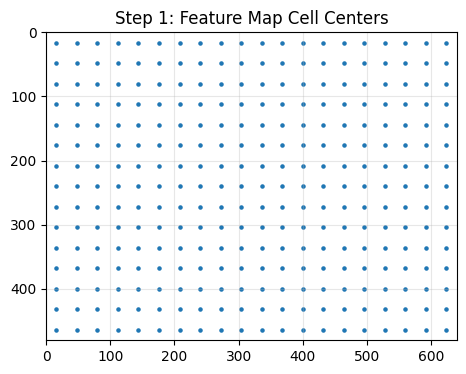

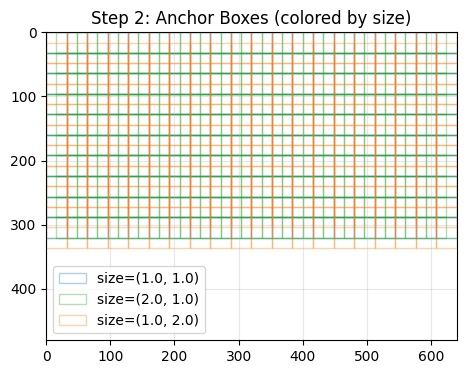

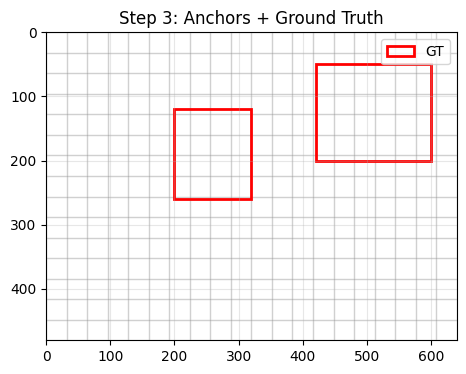

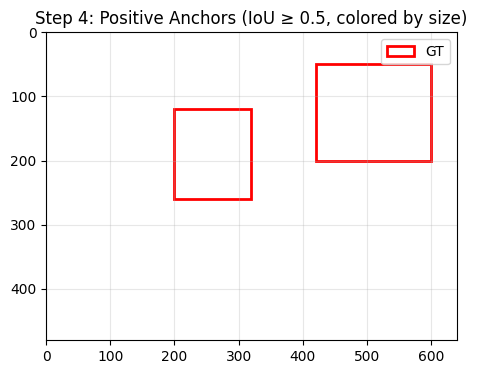

Step 5: Example deltas (tx,ty,tw,th)
[]


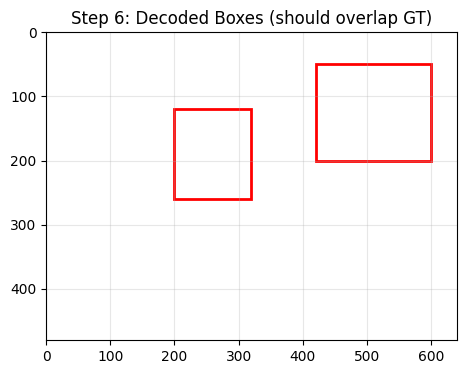

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# -------------------------
# 共通ユーティリティ
# -------------------------
def draw_boxes(ax, boxes, color="r", lw=1, alpha=1.0, label=None):
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        rect = Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=lw, edgecolor=color, facecolor="none", alpha=alpha
        )
        ax.add_patch(rect)
        if label and i == 0:
            rect.set_label(label)


def setup_canvas(W, H, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)  # 画像座標系
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
    return fig, ax


# -------------------------
# Step 0: 設定
# -------------------------
IMG_W, IMG_H = 640, 480
STRIDE = 32
FEAT_W, FEAT_H = IMG_W // STRIDE, IMG_H // STRIDE

ANCHOR_SIZES = [(1.0, 1.0), (2.0, 1.0), (1.0, 2.0)]

GT_BOXES = np.array([
    [200, 120, 320, 260],
    [420,  50, 600, 200],
])

# -------------------------
# Step 1: セル中心
# -------------------------
xs = (np.arange(FEAT_W) + 0.5) * STRIDE
ys = (np.arange(FEAT_H) + 0.5) * STRIDE
cx, cy = np.meshgrid(xs, ys)
centers = np.stack([cx, cy], axis=-1).reshape(-1, 2)

fig, ax = setup_canvas(IMG_W, IMG_H, "Step 1: Feature Map Cell Centers")
ax.scatter(centers[:, 0], centers[:, 1], s=5)
plt.show()

# -------------------------
# Step 2: アンカー生成（サイズ別）
# -------------------------
anchors_by_size = {}  # (sw,sh) -> anchors

for sw, sh in ANCHOR_SIZES:
    w = sw * STRIDE
    h = sh * STRIDE
    boxes = []
    for c in centers:
        x1 = c[0] - w / 2
        y1 = c[1] - h / 2
        x2 = c[0] + w / 2
        y2 = c[1] + h / 2
        boxes.append([x1, y1, x2, y2])
    anchors_by_size[(sw, sh)] = np.array(boxes)

# -------------------------
# Step 2 (描画): サイズ別に色分け
# -------------------------
COLOR_MAP = {
    (1.0, 1.0): "tab:blue",
    (2.0, 1.0): "tab:green",
    (1.0, 2.0): "tab:orange",
}

fig, ax = setup_canvas(IMG_W, IMG_H, "Step 2: Anchor Boxes (colored by size)")

for size, boxes in anchors_by_size.items():
    draw_boxes(
        ax,
        boxes[:200],          # 多すぎるので一部のみ
        color=COLOR_MAP[size],
        alpha=0.35,
        lw=1,
        label=f"size={size}"
    )

ax.legend()
plt.show()

# -------------------------
# Step 3: GTを重ねる
# -------------------------
fig, ax = setup_canvas(IMG_W, IMG_H, "Step 3: Anchors + Ground Truth")
draw_boxes(ax, anchors[:300], color="gray", alpha=0.2)
draw_boxes(ax, GT_BOXES, color="red", lw=2, label="GT")
ax.legend()
plt.show()

# -------------------------
# Step 4: IoU計算 & 正例抽出
# -------------------------
def iou(a, b):
    x1 = np.maximum(a[0], b[0])
    y1 = np.maximum(a[1], b[1])
    x2 = np.minimum(a[2], b[2])
    y2 = np.minimum(a[3], b[3])
    inter = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    area_a = (a[2]-a[0]) * (a[3]-a[1])
    area_b = (b[2]-b[0]) * (b[3]-b[1])
    return inter / (area_a + area_b - inter + 1e-9)

ious = np.zeros((anchors.shape[0], GT_BOXES.shape[0]))
for i, a in enumerate(anchors):
    for j, g in enumerate(GT_BOXES):
        ious[i, j] = iou(a, g)

best_iou = ious.max(axis=1)
best_gt = ious.argmax(axis=1)

POS_TH = 0.5
pos_idx = np.where(best_iou >= POS_TH)[0]

fig, ax = setup_canvas(
    IMG_W, IMG_H,
    "Step 4: Positive Anchors (IoU ≥ 0.5, colored by size)"
)

offset = 0
num_centers = centers.shape[0]

for (sw, sh), boxes in anchors_by_size.items():
    # このサイズに対応するアンカーの global index 範囲
    idx_range = np.arange(offset, offset + num_centers)
    offset += num_centers

    pos_mask = np.isin(idx_range, pos_idx)
    pos_boxes = boxes[pos_mask]

    draw_boxes(
        ax,
        pos_boxes,
        color=COLOR_MAP[(sw, sh)],
        lw=1.5,
        label=f"pos size={sw,sh}"
    )

draw_boxes(ax, GT_BOXES, color="red", lw=2, label="GT")
ax.legend()
plt.show()


# -------------------------
# Step 5: 回帰ターゲット（encode）
# -------------------------
def xyxy_to_cxcywh(b):
    return np.array([
        (b[0]+b[2])/2,
        (b[1]+b[3])/2,
        b[2]-b[0],
        b[3]-b[1],
    ])

encoded = []
for i in pos_idx:
    a = xyxy_to_cxcywh(anchors[i])
    g = xyxy_to_cxcywh(GT_BOXES[best_gt[i]])
    tx = (g[0]-a[0])/a[2]
    ty = (g[1]-a[1])/a[3]
    tw = np.log(g[2]/a[2])
    th = np.log(g[3]/a[3])
    encoded.append([tx, ty, tw, th])
encoded = np.array(encoded)

print("Step 5: Example deltas (tx,ty,tw,th)")
print(encoded[:5])

# -------------------------
# Step 6: decode（予測BBox）
# -------------------------
decoded = []
for i, d in zip(pos_idx, encoded):
    a = xyxy_to_cxcywh(anchors[i])
    cx = a[0] + d[0]*a[2]
    cy = a[1] + d[1]*a[3]
    w  = a[2] * np.exp(d[2])
    h  = a[3] * np.exp(d[3])
    decoded.append([cx-w/2, cy-h/2, cx+w/2, cy+h/2])
decoded = np.array(decoded)

fig, ax = setup_canvas(IMG_W, IMG_H, "Step 6: Decoded Boxes (should overlap GT)")
draw_boxes(ax, decoded, color="green", lw=1)
draw_boxes(ax, GT_BOXES, color="red", lw=2)
plt.show()
